In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = "{:,.2f}".format

from experiments import *

import sys

sys.path.insert(1, '../fuzzylearn/')

from fuzzylearn import *
from fuzzylearn.fuzzifiers import LinearFuzzifier, CrispFuzzifier,ExponentialFuzzifier,QuantileLinearPiecewiseFuzzifier, QuantileConstantPiecewiseFuzzifier
from fuzzylearn.kernel import GaussianKernel, LinearKernel, HyperbolicKernel, PolynomialKernel, HomogeneousPolynomialKernel
from fuzzylearn import solve_optimization_gurobi

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler, PowerTransformer, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.manifold import TSNE

In [2]:
dataset = pd.read_excel("dataset/IncidentiModificato.xlsx")
dataset = dataset.set_index("VERBALE")

import datetime as dt

dataset.DATA = dataset.DATA.apply(lambda d: (d - dt.datetime(1970,1,1)).days)

dataset.head()

,DATA,SESSO,ANNI,PESO,ALTEZZA,BMI,Mezzo,Testa:Neurocranio,Testa:Splancnocranio,Testa:Telencefalo,...,Scheletro:Rachide-cervicale,Scheletro:Rachide-toracico,Scheletro:Rachide-lombare,Scheletro:Bacino-e-sacro,Scheletro:Complesso-sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,10893,0,81,84.00,1.75,27.43,0,1,0,0,...,0,3,0,3,3,2,0,3,9,14
85829,10970,1,69,69.00,1.62,26.29,1,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,11026,1,71,67.00,1.55,27.89,1,2,0,1,...,0,0,0,0,4,6,0,0,4,10
86220,11122,1,54,60.00,1.59,23.73,1,4,0,0,...,0,0,0,0,4,5,3,2,4,14
86247,11130,1,78,69.00,1.67,24.74,1,2,0,0,...,0,0,0,0,4,2,0,2,4,8


In [3]:
from umap import UMAP

/home/manueldileo/anaconda3/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


## Incidenti best exp

In [4]:
from experiments import *

In [5]:
dim_red = UMAP(n_components=20)
scaling = QuantileTransformer(output_distribution='normal')

In [6]:
values = dataset[list(dataset.columns)[7:27]].values
values_std = scaling.fit_transform(values)
values_20d = dim_red.fit_transform(values_std)

/home/manueldileo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (130). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


In [7]:
classes = (1,0)

be1 = FuzzyInductor(fuzzifier=ExponentialFuzzifier,c=0.021544346900318846,k=HyperbolicKernel(1,0))
be0 = FuzzyInductor(fuzzifier=LinearFuzzifier,c=0.021544346900318846,k=LinearKernel())
bes = [be1,be0]

In [10]:
dataset_labels = dataset['Mezzo'].values

In [10]:
perf_train, perf_test =best_estimator_holdout(bes,dataset.index,values_20d, dataset_labels,
                                              classes,0.7,classify,5)

100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


In [11]:
perf_train, perf_test

(0.5252747252747252, 0.5692307692307693)

## Visualizzazione UMAP 2 Componenti da DF PCA 1

In [21]:
import matplotlib.pyplot as plt

def gr_dataset(df): 
    for lab, col in zip((0, 1),
                        ('blue', 'red')):
        plt.scatter(df.values[labels.values==lab, 0],
                    df.values[labels.values==lab, 1],
                    label=lab,
                    c=col)

In [22]:
def gr_membership_contour(estimated_membership):
    x = np.arange(-10, 10, .1)
    y = np.arange(-10, 10, .1)
    X, Y = np.meshgrid(x, y)
    zs = np.array([estimated_membership((x, y))
                   for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    membership_contour = plt.contour(X, Y, Z,
                                     levels=(.1, .3, .5, .95), colors='k')
    plt.clabel(membership_contour, inline=1)

In [5]:
anagrafica = dataset[list(dataset.columns)[1:6]]
labels = dataset['Mezzo']
lesioni = dataset[list(dataset.columns)[7:27]]

In [6]:
labels_zone = ['Testa','Torace','Addome','Scheletro']

In [7]:
df_compresso = anagrafica.copy()
for i,l in zip(range(0,len(lesioni.columns),5),labels_zone):
    zona = lesioni[list(lesioni.columns)[i:(i+5)]]
    component = PCA(n_components=1).fit_transform(zona.values)
    component_to_values = [v[0] for v in component]
    serie = pd.Series(component_to_values,index=zona.index)
    df_compresso[l] = serie

In [26]:
df_compresso.tail()

,SESSO,ANNI,PESO,ALTEZZA,BMI,Testa,Torace,Addome,Scheletro
VERBALE,,,,,,,,,
101618,1,82,80.20,1.62,30.56,-1.64,-0.92,-1.29,-3.13
101288E,1,70,75.60,1.57,30.67,-1.11,-1.50,-1.29,-1.02
E-97586,0,45,45.00,1.77,14.36,-2.17,-0.91,-1.29,1.65
X,0,54,89.60,1.68,31.75,-1.38,-0.60,-0.15,0.66
X1,1,86,50.00,1.55,20.81,-0.90,-0.60,1.03,1.65


In [8]:
umap_values = UMAP(n_components=2).fit_transform\
            (StandardScaler().fit_transform(df_compresso.values))
df_umap=pd.DataFrame(umap_values,index=dataset.index)
df_umap.head()

,0,1
VERBALE,,
85567,0.23,9.40
85829,5.38,11.73
85977,7.55,12.95
86220,8.02,12.09
86247,7.28,12.74


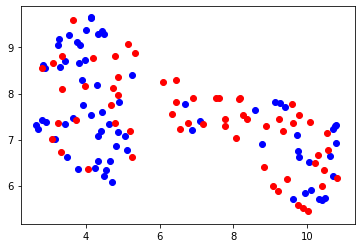

In [15]:
gr_dataset(df_umap)

In [12]:
ordini = [.01,.1,1,10,100,1000]
pg_ordini = {
    'c': ordini,
    'k': [GaussianKernel(sigma) for sigma in ordini]+\
         [LinearKernel()]+\
         [HyperbolicKernel(1,o) for o in ordini]
}

In [9]:
import logging

# create logger
f_logger = logging.getLogger(__name__)
f_logger.setLevel(logging.INFO)

# create console handler and set level to debug
file = logging.FileHandler('esperimenti_umap.log')
file.setLevel(logging.INFO)

# create formatter
formatter = logging.Formatter('%(asctime)s -%(message)s')

# add formatter to ch
file.setFormatter(formatter)

# add ch to logger
f_logger.addHandler(file)

In [35]:
l = 'UMAP2_MSOrdine'

In [15]:
filejson = 'json_result/fuzzifiers_umap.json'

In [36]:
ft = incidenti_fuzzifier_table(df_umap,[list(df_umap.columns)],fuzzifiers_class,FuzzyInductor,dataset_labels,\
                               pg_ordini, 3,3,logger=f_logger,scaling=None,labels=[l], file_json=filejson)
ft.to_json(filejson)

In [37]:
pg_fine = {
    'c': [.1,.2,.3,.4,.5,.6,.7,.8,.9],
    'k': [GaussianKernel(sigma) for sigma in [.01,.02,.03,.04,.05,.06,.07,.08,.09]]
}
l = 'UMAP2_MSFine'

In [38]:
ft = incidenti_fuzzifier_table(df_umap,[list(df_umap.columns)],fuzzifiers_class,FuzzyInductor,dataset_labels,\
                               pg_fine, 3,3,logger=f_logger,scaling=None,labels=[l], file_json=filejson)
ft.to_json(filejson)

In [17]:
l='UMAP2_MSOrdine_0'
mu0 = [1 if not label else 0 for label in dataset_labels]

In [18]:
ft = incidenti_fuzzifier_table(df_umap,[list(df_umap.columns)],fuzzifiers_class,FuzzyInductor,dataset_labels,\
                               pg_ordini, 3,3,logger=None,scaling=None,labels=[l], file_json=filejson)
ft.to_json(filejson)

In [42]:
ft

,UMAP2_MSOrdine,UMAP2_MSFine,UMAP2_MSOrdine_0
QuantileConstantPiecewiseFuzzifier,-0.33,-0.33,-0.61
CrispFuzzifier,-0.46,-0.46,-0.46
ExponentialFuzzifier,-0.46,-0.46,-0.45
LinearFuzzifier,-0.46,-0.46,-0.45
QuantileLinearPiecewiseFuzzifier,-0.33,-0.33,-0.61


In [12]:
from defuzzification import *
from functools import partial

In [13]:
classes=(1,0)

In [46]:
be = FuzzyInductor(k=GaussianKernel(.01),c=.1,\
                   fuzzifier=QuantileConstantPiecewiseFuzzifier)
bes = [be,FuzzyInductor()]
for alpha in np.arange(.3,.9,.05):
    perf_train,perf_test = best_estimator_holdout(bes,df_umap.index,\
                                                  df_umap.values,\
                                                  dataset_labels,\
                                              classes,0.7,\
                                            partial(alpha_cut,alpha,1),2)
    print("alpha-cut {}: {} , {}".format(alpha,perf_train,perf_test))

100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


alpha-cut 0.3: 0.5494505494505495 , 0.5128205128205128


100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


alpha-cut 0.35: 0.5164835164835165 , 0.5897435897435896


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


alpha-cut 0.39999999999999997: 0.5384615384615385 , 0.5384615384615384


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


alpha-cut 0.44999999999999996: 0.5384615384615384 , 0.5384615384615384


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


alpha-cut 0.49999999999999994: 0.5494505494505495 , 0.5128205128205128


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


alpha-cut 0.5499999999999999: 0.521978021978022 , 0.5769230769230769


100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


alpha-cut 0.5999999999999999: 0.5659340659340659 , 0.47435897435897434


100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


alpha-cut 0.6499999999999999: 0.5824175824175823 , 0.4358974358974359


100%|██████████| 100/100 [00:21<00:00,  4.60it/s]


alpha-cut 0.7: 0.5824175824175825 , 0.4358974358974359


100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


alpha-cut 0.7499999999999999: 0.5494505494505495 , 0.5128205128205128


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


alpha-cut 0.7999999999999998: 0.4230769230769231 , 0.5


100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


alpha-cut 0.8499999999999999: 0.4340659340659341 , 0.47435897435897434


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


alpha-cut 0.8999999999999999: 0.02197802197802198 , 0.47435897435897434


In [47]:
for alpha in [.95,1]:
    perf_train,perf_test = best_estimator_holdout(bes,df_umap.index,\
                                                  df_umap.values,\
                                                  dataset_labels,\
                                              classes,0.7,\
                                            partial(alpha_cut,alpha,1),2)
    print("alpha-cut {}: {} , {}".format(alpha,perf_train,perf_test))

100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


alpha-cut 0.95: 0.24175824175824176 , 0.47435897435897434


100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


alpha-cut 1: 0.20879120879120877 , 0.47435897435897434


## Lesioni20UMAP

In [14]:
columns_lesioni = list(lesioni.columns)

In [15]:
labels = ['Lesioni5UMAP','Lesioni10UMAP','Lesioni15UMAP','Lesioni20UMAP']

In [29]:
for c,l in zip([5,10,15,20],labels):
    ft = incidenti_fuzzifier_table(dataset,[columns_lesioni],fuzzifiers_class,FuzzyInductor,dataset_labels,\
                               pg_ordini, 3,3,logger=f_logger,scaling=StandardScaler(),\
                               dim_reduction=UMAP(n_components=c),labels=[l], file_json=filejson)
    ft.to_json(filejson)

/home/manueldileo/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:788: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
100%|██████████| 100/100 [00:29<00:00,  3.43it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:20<00:00,  4.96it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:19<00:00,  5.08it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:20<00:00,  4.93it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/

In [30]:
ft

,UMAP2_MSOrdine,UMAP2_MSFine,UMAP2_MSOrdine_0,Lesioni5UMAP,Lesioni10UMAP,Lesioni15UMAP,Lesioni20UMAP
QuantileConstantPiecewiseFuzzifier,-0.33,-0.33,-0.61,-0.33,-0.33,-0.33,-0.33
CrispFuzzifier,-0.46,-0.46,-0.46,-0.46,-0.46,-0.43,-0.46
ExponentialFuzzifier,-0.46,-0.46,-0.45,-0.46,-0.46,-0.46,-0.46
LinearFuzzifier,-0.46,-0.46,-0.45,-0.46,-0.45,-0.47,-0.46
QuantileLinearPiecewiseFuzzifier,-0.33,-0.33,-0.61,-0.33,-0.34,-0.34,-0.33


c = .1, k = GaussianKernel(.01)

In [22]:
labels_0 = list(map(lambda x: x + "_0",labels))

In [23]:
for c,l in zip([5,10,15,20],labels_0):
    ft = incidenti_fuzzifier_table(dataset,[columns_lesioni],fuzzifiers_class,FuzzyInductor,mu0,\
                               pg_ordini, 3,3,logger=f_logger,scaling=StandardScaler(),\
                               dim_reduction=UMAP(n_components=c),labels=[l], file_json=filejson)
    ft.to_json(filejson)

/home/manueldileo/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:788: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
100%|██████████| 100/100 [00:34<00:00,  2.94it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:23<00:00,  4.25it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:23<00:00,  4.26it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:23<00:00,  4.21it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/

In [24]:
ft

,UMAP2_MSOrdine,UMAP2_MSFine,UMAP2_MSOrdine_0,Lesioni5UMAP,Lesioni10UMAP,Lesioni15UMAP,Lesioni20UMAP,Lesioni5UMAP_0,Lesioni10UMAP_0,Lesioni15UMAP_0,Lesioni20UMAP_0
QuantileConstantPiecewiseFuzzifier,-0.33,-0.33,-0.61,-0.33,-0.33,-0.33,-0.33,-0.33,-0.30,-0.32,-0.31
CrispFuzzifier,-0.46,-0.46,-0.46,-0.46,-0.46,-0.43,-0.46,-0.46,-0.44,-0.46,-0.41
ExponentialFuzzifier,-0.46,-0.46,-0.45,-0.46,-0.46,-0.46,-0.46,-0.31,-0.31,-0.31,-0.31
LinearFuzzifier,-0.46,-0.46,-0.45,-0.46,-0.45,-0.47,-0.46,-0.26,-0.26,-0.26,-0.26
QuantileLinearPiecewiseFuzzifier,-0.33,-0.33,-0.61,-0.33,-0.34,-0.34,-0.33,-0.41,-0.41,-0.41,-0.41


In [12]:
pgfine = {
    'c': [.1],
    'k': [GaussianKernel(sigma) for sigma in np.arange(.01,.1,.01)]
}

In [13]:
l = 'Lesioni20UMAPFine'

In [14]:
ft = incidenti_fuzzifier_table(dataset,[columns_lesioni],fuzzifiers_class,FuzzyInductor,dataset_labels,\
                               pgfine, 3,3,logger=f_logger,scaling=StandardScaler(),\
                               dim_reduction=UMAP(n_components=20),labels=[l], file_json=filejson)
ft.to_json(filejson)

100%|██████████| 100/100 [00:26<00:00,  3.77it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:18<00:00,  5.27it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:20<00:00,  4.89it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:20<00:00,  4.96it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


In [18]:
pgfine0 = {
    'c': [.1],
    'k': [GaussianKernel(sigma) for sigma in range(1,10)]
}
l='Lesioni20UMAPFine_0'

In [19]:
ft = incidenti_fuzzifier_table(dataset,[columns_lesioni],fuzzifiers_class,FuzzyInductor,mu0,\
                               pgfine0, 3,3,logger=f_logger,scaling=StandardScaler(),\
                               dim_reduction=UMAP(n_components=20),labels=[l], file_json=filejson)
ft.to_json(filejson)

100%|██████████| 100/100 [00:26<00:00,  3.74it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:18<00:00,  5.34it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:19<00:00,  5.18it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:20<00:00,  4.92it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


In [20]:
ft

,UMAP2_MSOrdine,UMAP2_MSFine,UMAP2_MSOrdine_0,Lesioni5UMAP,Lesioni10UMAP,Lesioni15UMAP,Lesioni20UMAP,Lesioni5UMAP_0,Lesioni10UMAP_0,Lesioni15UMAP_0,Lesioni20UMAP_0,Lesioni20UMAPFine,Lesioni20UMAPFine_0
QuantileConstantPiecewiseFuzzifier,-0.33,-0.33,-0.61,-0.33,-0.33,-0.33,-0.33,-0.33,-0.30,-0.32,-0.31,-0.33,-0.32
CrispFuzzifier,-0.46,-0.46,-0.46,-0.46,-0.46,-0.43,-0.46,-0.46,-0.44,-0.46,-0.41,-0.46,-0.41
ExponentialFuzzifier,-0.46,-0.46,-0.45,-0.46,-0.46,-0.46,-0.46,-0.31,-0.31,-0.31,-0.31,-0.46,-0.31
LinearFuzzifier,-0.46,-0.46,-0.45,-0.46,-0.45,-0.47,-0.46,-0.26,-0.26,-0.26,-0.26,-0.46,-0.26
QuantileLinearPiecewiseFuzzifier,-0.33,-0.33,-0.61,-0.33,-0.34,-0.34,-0.33,-0.41,-0.41,-0.41,-0.41,-0.33,-0.41


## BMILesioni

In [15]:
columns_bmi_lesioni = list(anagrafica.columns) + columns_lesioni

In [16]:
l = 'BMILesioni20UMAP'

In [17]:
ft = incidenti_fuzzifier_table(dataset,[columns_bmi_lesioni],\
                               fuzzifiers_class,FuzzyInductor,\
                               dataset_labels,\
                               pg_ordini, 3,3,logger=f_logger,\
                               scaling=StandardScaler(),\
                               dim_reduction=UMAP(n_components=20),\
                               labels=[l], file_json=filejson)
ft.to_json(filejson)

/home/manueldileo/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:788: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:20<00:00,  4.97it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:20<00:00,  4.85it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:20<00:00,  4.82it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/

In [18]:
l = 'BMILesioni20UMAP_0'

In [19]:
ft = incidenti_fuzzifier_table(dataset,[columns_bmi_lesioni],\
                               fuzzifiers_class,FuzzyInductor,\
                               mu0,\
                               pg_ordini, 3,3,logger=f_logger,\
                               scaling=StandardScaler(),\
                               dim_reduction=UMAP(n_components=20),\
                               labels=[l], file_json=filejson)
ft.to_json(filejson)

/home/manueldileo/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:788: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:20<00:00,  4.95it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:20<00:00,  4.86it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 100/100 [00:20<00:00,  4.85it/s]
/home/manueldileo/anaconda3/lib/python3.7/site-packages/scipy/

In [20]:
ft

,UMAP2_MSOrdine,UMAP2_MSFine,UMAP2_MSOrdine_0,Lesioni5UMAP,Lesioni10UMAP,Lesioni15UMAP,Lesioni20UMAP,Lesioni5UMAP_0,Lesioni10UMAP_0,Lesioni15UMAP_0,Lesioni20UMAP_0,Lesioni20UMAPFine,Lesioni20UMAPFine_0,BMILesioni20UMAP,BMILesioni20UMAP_0
QuantileConstantPiecewiseFuzzifier,-0.33,-0.33,-0.61,-0.33,-0.33,-0.33,-0.33,-0.33,-0.30,-0.32,-0.31,-0.33,-0.32,-0.33,-0.32
CrispFuzzifier,-0.46,-0.46,-0.46,-0.46,-0.46,-0.43,-0.46,-0.46,-0.44,-0.46,-0.41,-0.46,-0.41,-0.46,-0.45
ExponentialFuzzifier,-0.46,-0.46,-0.45,-0.46,-0.46,-0.46,-0.46,-0.31,-0.31,-0.31,-0.31,-0.46,-0.31,-0.46,-0.31
LinearFuzzifier,-0.46,-0.46,-0.45,-0.46,-0.45,-0.47,-0.46,-0.26,-0.26,-0.26,-0.26,-0.46,-0.26,-0.46,-0.26
QuantileLinearPiecewiseFuzzifier,-0.33,-0.33,-0.61,-0.33,-0.34,-0.34,-0.33,-0.41,-0.41,-0.41,-0.41,-0.33,-0.41,-0.33,-0.41
